In [1]:
import pandas as pd
import numpy as np

import folium
import geocoder
from geopy.geocoders import Nominatim

import requests

from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

import re

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 500)

## Neighborhoods and location data

Retrieving neighborhoods list from the wikipedia page

In [2]:
link = 'https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Seattle'
seattle = pd.read_html(link, header=0)[0]
seattle = seattle.iloc[:,1:3]
seattle.head()

,Neighborhood name,Within larger district
0,North Seattle,Seattle
1,Broadview,North Seattle[42]
2,Bitter Lake,North Seattle[42]
3,North Beach / Blue Ridge,North Seattle[42]
4,Crown Hill,North Seattle[42]


In [3]:
seattle.columns = ['neighborhood','district']
seattle.head()

,neighborhood,district
0,North Seattle,Seattle
1,Broadview,North Seattle[42]
2,Bitter Lake,North Seattle[42]
3,North Beach / Blue Ridge,North Seattle[42]
4,Crown Hill,North Seattle[42]


Cleaning the data: removing square bracket references, alternative neighborhood names

In [4]:
seattle.neighborhood = seattle.neighborhood.apply(lambda x: re.sub('\[.*?\]|\ /.*|\(.*?\)', '', x,flags=re.DOTALL))
seattle.district = seattle.district.apply(lambda x: re.sub('\[.*?\]', '', x,flags=re.DOTALL))
seattle.head()

,neighborhood,district
0,North Seattle,Seattle
1,Broadview,North Seattle
2,Bitter Lake,North Seattle
3,North Beach,North Seattle
4,Crown Hill,North Seattle


Removing large neighborhoods, which have smaller ones

In [5]:
seattle = seattle[~seattle.neighborhood.isin(seattle.district.unique())]
seattle.head()

,neighborhood,district
1,Broadview,North Seattle
2,Bitter Lake,North Seattle
3,North Beach,North Seattle
4,Crown Hill,North Seattle
5,Greenwood,North Seattle


Retrieving neighborhoods latitudes and longitudes

In [6]:
locator = Nominatim(user_agent="myGeocoder")
seattle['latitude'] = None
seattle['longitude'] = None
for n in seattle.neighborhood:
    location = locator.geocode("{}, Seattle, WA".format(n))
    if location is not None:
        seattle.loc[seattle.neighborhood==n, 'latitude'] = location.latitude
        seattle.loc[seattle.neighborhood==n, 'longitude'] = location.longitude

In [7]:
seattle = seattle[~seattle.latitude.isnull()]
seattle.head()

,neighborhood,district,latitude,longitude
1,Broadview,North Seattle,47.7223,-122.36
2,Bitter Lake,North Seattle,47.7262,-122.349
3,North Beach,North Seattle,47.6962,-122.392
4,Crown Hill,North Seattle,47.6947,-122.371
5,Greenwood,North Seattle,47.691,-122.355


In [8]:
location = locator.geocode('Seattle, WA')
latitude, longitude = location.latitude, location.longitude

seattle_map = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, neighborhood in zip(seattle['latitude'], seattle['longitude'], seattle['neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.7,
        parse_html=False).add_to(seattle_map)  
    
seattle_map

## Venues data

Getting neighborhoods venues data by latitude and longitude from Foursquare

In [9]:
CLIENT_ID = 'OXLFWOLNGBKWFDNYBU3CLIDOR4MNS5WHJ4L3DLIDCHL1GFN4' 
CLIENT_SECRET = 'PV1VFTJLJVQ4RFSQPUA3BXYTSUURCCH4YKAYMOTWDSGEVFCE' 
VERSION = '20201112'
LIMIT = 100

In [10]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)

        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    print(nearby_venues)
    return(nearby_venues)

In [11]:
seattle_venues = getNearbyVenues(names=seattle['neighborhood'], latitudes=seattle['latitude'], longitudes=seattle['longitude'])

Broadview
Bitter Lake
North Beach
Crown Hill
Greenwood
Haller Lake
Pinehurst
Maple Leaf
Cedar Park
Matthews Beach
Meadowbrook
Olympic Hills
Victory Heights
Wedgwood
View Ridge
Sand Point
Roosevelt
Ravenna
Bryant
Windermere
Hawthorne Hills
Laurelhurst
University District 
University Village
Wallingford
Northlake
Green Lake
Fremont
Phinney Ridge
West Woodland
Whittier Heights
Adams
Sunset Hill
Loyal Heights
Lawton Park
Briarcliff
Southeast Magnolia
Interbay
North Queen Anne
East Queen Anne
Lower Queen Anne
West Queen Anne
Portage Bay
Broadway
Montlake
Stevens
Interlaken
Madison Valley
Renton Hill
Broadmoor
South Lake Union, Seattle
Cascade, Seattle
Westlake
Eastlake
Denny Triangle
Belltown
Pike-Market
Central Business District
First Hill
Pioneer Square
International District 
Yesler Terrace
Central Waterfront
West Edge
Mann
Judkins Park
Madrona Valley
Harrison
Washington Park
Leschi
Mount Baker
Columbia City
Hillman City
Brighton
Dunlap
Rainier Beach
Rainier View
Lakewood
North Beacon Hi

In [12]:
print(seattle_venues.shape)
seattle_venues.head()

(2933, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Broadview,47.72232,-122.360407,Wicked Good Grinders,47.719657,-122.355966,Food Truck
1,Broadview,47.72232,-122.360407,Chada Thai,47.719663,-122.355114,Thai Restaurant
2,Broadview,47.72232,-122.360407,Broadview Tap House,47.719337,-122.356152,Beer Bar
3,Broadview,47.72232,-122.360407,Redbox,47.719600,-122.355579,Video Store
4,Broadview,47.72232,-122.360407,7-Eleven,47.719941,-122.355229,Convenience Store


One-hot encoding for venue categories

In [13]:
seattle_onehot = pd.get_dummies(seattle_venues[['Venue Category']], prefix="", prefix_sep="")
seattle_onehot['Neighbourhood'] = seattle_venues['Neighborhood'] 

fixed_columns = [seattle_onehot.columns[-1]] + list(seattle_onehot.columns[:-1])
seattle_onehot = seattle_onehot[fixed_columns]

print(seattle_onehot.shape)
seattle_onehot.head()

(2933, 310)


,Neighbourhood,ATM,Accessories Store,African Restaurant,American Restaurant,Amphitheater,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Dealership,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Shop,Bike Trail,Bistro,Boat Rental,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Casino,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Theater,Comedy Club,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Fabric Shop,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Financial or Legal Service,Fish & Chips Shop,Fish Market,Floating Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Home Service,Hostel,...,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Knitting Store,Korean Restaurant,Lake,Lebanese Restaurant,Library,Light Rail Station,Lighthouse,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Nightlife,Outdoor Sculpture,Outdoor Supply Store,Paper / Office Supplies Store,Park,Parking,Pawn Shop,Peking Duck Restaurant,Performing Arts Venue,Pet Service,Pet Store,Pharmacy,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Post Office,Print Shop,Pub,Radio Station,Ramen Restaurant,Record Shop,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Resort,Restaurant,Rock Club,Rugby Pitch,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Repair,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Ski Area,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Storage Facility,Strip Club,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tour Provider,Tourist Information Center,Toy / Game Store,Track,Trail,Trailer Park,Tram Station,Tunnel,Turkish Restaurant,U

Mean frequencies for each venue category by neighborhood

In [14]:
seattle_grouped = seattle_onehot.groupby('Neighbourhood').mean().reset_index()
print(seattle_grouped.shape)
seattle_grouped

(100, 310)


,Neighbourhood,ATM,Accessories Store,African Restaurant,American Restaurant,Amphitheater,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Dealership,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Shop,Bike Trail,Bistro,Boat Rental,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Casino,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Theater,Comedy Club,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Fabric Shop,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Financial or Legal Service,Fish & Chips Shop,Fish Market,Floating Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Home Service,Hostel,...,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Knitting Store,Korean Restaurant,Lake,Lebanese Restaurant,Library,Light Rail Station,Lighthouse,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Nightlife,Outdoor Sculpture,Outdoor Supply Store,Paper / Office Supplies Store,Park,Parking,Pawn Shop,Peking Duck Restaurant,Performing Arts Venue,Pet Service,Pet Store,Pharmacy,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Post Office,Print Shop,Pub,Radio Station,Ramen Restaurant,Record Shop,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Resort,Restaurant,Rock Club,Rugby Pitch,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Repair,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Ski Area,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Storage Facility,Strip Club,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tour Provider,Tourist Information Center,Toy / Game Store,Track,Trail,Trailer Park,Tram Station,Tunnel,Turkish Restaurant,U

Determining the top venues for each neighborhood

In [15]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [16]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = seattle_grouped['Neighbourhood']

for ind in np.arange(seattle_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(seattle_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adams,Coffee Shop,Vietnamese Restaurant,Korean Restaurant,Park,Sandwich Place,Eastern European Restaurant,Burger Joint,Thai Restaurant,German Restaurant,Mexican Restaurant
1,Alki Point,Beach,Baseball Field,Baseball Stadium,Scenic Lookout,Lighthouse,Zoo Exhibit,Field,Falafel Restaurant,Farm,Farmers Market
2,Arbor Heights,Bus Station,Zoo Exhibit,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Financial or Legal Service,Fish & Chips Shop
3,Belltown,Bar,Hotel,Coffee Shop,Sushi Restaurant,Seafood Restaurant,Gym,Bakery,Cocktail Bar,Breakfast Spot,Italian Restaurant
4,Bitter Lake,Fast Food Restaurant,Ice Cream Shop,Gym,Szechuan Restaurant,Seafood Restaurant,Sandwich Place,Pet Store,Noodle House,Mobile Phone Shop,Hotpot Restaurant


## Clustering

Finding out the optimum number of clusters with an elbow method

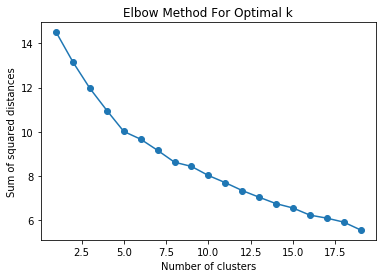

In [17]:
seattle_grouped_clust = seattle_grouped.iloc[:,1:]
ssd = []
K = range(1,20)
for k in K:
    km = KMeans(n_clusters=k,random_state=42)
    km = km.fit(seattle_grouped_clust)
    ssd.append(km.inertia_)
    
plt.plot(K, ssd, 'o-')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Running k-means with number of clusters = 5

In [18]:
k = 5
km = KMeans(n_clusters=k, random_state=42).fit(seattle_grouped_clust)

In [19]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', km.labels_)

seattle_merged = seattle
seattle_merged = seattle_merged.merge(neighborhoods_venues_sorted.set_index('Neighbourhood'), right_on='Neighbourhood', left_on='neighborhood')

seattle_merged.head()

,neighborhood,district,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Broadview,North Seattle,47.7223,-122.36,0,Food Truck,Pizza Place,Beer Bar,Sushi Restaurant,Resort,Furniture / Home Store,Video Store,Thai Restaurant,Antique Shop,Convenience Store
1,Bitter Lake,North Seattle,47.7262,-122.349,0,Fast Food Restaurant,Ice Cream Shop,Gym,Szechuan Restaurant,Seafood Restaurant,Sandwich Place,Pet Store,Noodle House,Mobile Phone Shop,Hotpot Restaurant
2,North Beach,North Seattle,47.6962,-122.392,4,Beach,Park,Financial or Legal Service,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Zoo Exhibit
3,Crown Hill,North Seattle,47.6947,-122.371,0,Pet Store,Sports Bar,Mexican Restaurant,Fast Food Restaurant,Taco Place,Grocery Store,Sandwich Place,Burger Joint,Coffee Shop,Pizza Place
4,Greenwood,North Seattle,47.691,-122.355,0,Coffee Shop,Mexican Restaurant,Spa,Bar,Pizza Place,Bookstore,Toy / Game Store,French Restaurant,Bakery,Theater


In [20]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, k))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(seattle_merged['latitude'], seattle_merged['longitude'], seattle_merged['neighborhood'], seattle_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examining clusters

In [21]:
seattle_merged.loc[seattle_merged['Cluster Labels'] == 0, seattle_merged.columns[[0] + list(range(5, seattle_merged.shape[1]))]].reset_index(drop=True)

,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Broadview,Food Truck,Pizza Place,Beer Bar,Sushi Restaurant,Resort,Furniture / Home Store,Video Store,Thai Restaurant,Antique Shop,Convenience Store
1,Bitter Lake,Fast Food Restaurant,Ice Cream Shop,Gym,Szechuan Restaurant,Seafood Restaurant,Sandwich Place,Pet Store,Noodle House,Mobile Phone Shop,Hotpot Restaurant
2,Crown Hill,Pet Store,Sports Bar,Mexican Restaurant,Fast Food Restaurant,Taco Place,Grocery Store,Sandwich Place,Burger Joint,Coffee Shop,Pizza Place
3,Greenwood,Coffee Shop,Mexican Restaurant,Spa,Bar,Pizza Place,Bookstore,Toy / Game Store,French Restaurant,Bakery,Theater
4,Haller Lake,Coffee Shop,Dance Studio,Lake,Playground,Scenic Lookout,Park,Fast Food Restaurant,Fabric Shop,Fair,Falafel Restaurant
5,Pinehurst,Coffee Shop,Hotel,Café,Cocktail Bar,Japanese Restaurant,Park,Italian Restaurant,Gym,Donut Shop,Pizza Place
6,Maple Leaf,Coffee Shop,Toy / Game Store,Video Store,Ice Cream Shop,Hawaiian Restaurant,Gym / Fitness Center,Music Store,Flower Shop,Dive Bar,Restaurant
7,Cedar Park,Supermarket,Vietnamese Restaurant,Zoo Exhibit,Fish & Chips Shop,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field
8,Meadowbrook,Soccer Field,Restaurant,Pizza Place,Park,Coffee Shop,Zoo Exhibit,Event Space,Fabric Shop,Fair,Falafel Restaurant
9,Olympic Hills,Farmers Market,Middle Eastern Restaurant,Zoo Exhibit,Fish Market,Falafel Restaurant,Farm,Fast Food Restaurant,Field,Financial or Legal Service,Fish & Chips Shop


Further exploration of cluster 0

In [22]:
cluster_0 = seattle_merged.loc[seattle_merged['Cluster Labels'] == 0, seattle_merged.columns[[0] + list(range(5, seattle_merged.shape[1]))]]

#drop the neighborhoods that already have a top venue Coffee Shop
cluster_0 = cluster_0[cluster_0.ne('Coffee Shop').all(1)]

#select the neighborhoods, which have other food places among its top venues
cluster_0[((np.column_stack([cluster_0[col].str.contains('Restaurant|Café|Bar') for col in cluster_0.columns])).any(1))].reset_index(drop=True)

,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Broadview,Food Truck,Pizza Place,Beer Bar,Sushi Restaurant,Resort,Furniture / Home Store,Video Store,Thai Restaurant,Antique Shop,Convenience Store
1,Bitter Lake,Fast Food Restaurant,Ice Cream Shop,Gym,Szechuan Restaurant,Seafood Restaurant,Sandwich Place,Pet Store,Noodle House,Mobile Phone Shop,Hotpot Restaurant
2,Cedar Park,Supermarket,Vietnamese Restaurant,Zoo Exhibit,Fish & Chips Shop,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field
3,Olympic Hills,Farmers Market,Middle Eastern Restaurant,Zoo Exhibit,Fish Market,Falafel Restaurant,Farm,Fast Food Restaurant,Field,Financial or Legal Service,Fish & Chips Shop
4,Victory Heights,Garden,Marijuana Dispensary,Business Service,Playground,Zoo Exhibit,Financial or Legal Service,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
5,Hawthorne Hills,Dry Cleaner,Massage Studio,Bank,Automotive Shop,Café,Pharmacy,Hardware Store,Park,American Restaurant,Fish Market
6,Laurelhurst,Pharmacy,Bus Stop,Park,Gift Shop,Café,Playground,Cafeteria,Zoo Exhibit,Farm,Farmers Market
7,Northlake,Seafood Restaurant,Park,Bus Stop,Harbor / Marina,Eastern European Restaurant,Diner,Pizza Place,Boat or Ferry,Lounge,Art Gallery
8,Phinney Ridge,Zoo Exhibit,Bar,Café,Pizza Place,Dessert Shop,Music Venue,Salon / Barbershop,Pub,Playground,Pie Shop
9,West Woodland,Zoo Exhibit,Pizza Place,Pie Shop,Theme Park Ride / Attraction,Chinese Restaurant,Café,Park,Trail,Garden,New American Restaurant


Creating a list of neighborhoods for a potential coffee shop

In [23]:
potential_places = []
potential_places.extend(cluster_0[((np.column_stack([cluster_0[col].str.contains('Restaurant|Café|Bar') for col in cluster_0.columns])).any(1))].neighborhood)

In [24]:
seattle_merged.loc[seattle_merged['Cluster Labels'] == 1, seattle_merged.columns[[0] + list(range(5, seattle_merged.shape[1]))]]

,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
89,Genesee,Bus Station,Track,Golf Course,Gym,Soccer Field,Field,Fair,Falafel Restaurant,Farm,Farmers Market
92,Arbor Heights,Bus Station,Zoo Exhibit,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Financial or Legal Service,Fish & Chips Shop
99,High Point,Bus Station,Field,Playground,Zoo Exhibit,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Financial or Legal Service


In [25]:
seattle_merged.loc[seattle_merged['Cluster Labels'] == 2, seattle_merged.columns[[0] + list(range(5, seattle_merged.shape[1]))]]

,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Bryant,Organic Grocery,Zoo Exhibit,Financial or Legal Service,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop


In [26]:
seattle_merged.loc[seattle_merged['Cluster Labels'] == 3, seattle_merged.columns[[0] + list(range(5, seattle_merged.shape[1]))]]

,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
79,Holly Park,Playground,Fish & Chips Shop,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Financial or Legal Service,Zoo Exhibit
96,Highland Park,Baseball Field,Playground,Zoo Exhibit,Financial or Legal Service,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field


In [27]:
seattle_merged.loc[seattle_merged['Cluster Labels'] == 4, seattle_merged.columns[[0] + list(range(5, seattle_merged.shape[1]))]].reset_index(drop=True)

,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North Beach,Beach,Park,Financial or Legal Service,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Zoo Exhibit
1,Matthews Beach,Trail,Playground,Park,Zoo Exhibit,Field,Fabric Shop,Fair,Falafel Restaurant,Farm,Farmers Market
2,View Ridge,Park,Bus Stop,Art Gallery,Food Court,Financial or Legal Service,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
3,Windermere,Greek Restaurant,Park,Pizza Place,Food & Drink Shop,Fast Food Restaurant,Food Court,Fabric Shop,Fair,Falafel Restaurant,Farm
4,Green Lake,Park,Trail,Theater,Tennis Court,Beach,Zoo Exhibit,Event Space,Fair,Falafel Restaurant,Farm
5,Briarcliff,Bus Stop,Athletics & Sports,Trail,Park,Food,Farmers Market,Fabric Shop,Food Court,Fair,Falafel Restaurant
6,Interlaken,Park,Cemetery,Scenic Lookout,Ethiopian Restaurant,Fabric Shop,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
7,Leschi,Park,Grocery Store,Pet Store,Pizza Place,Bus Stop,Zoo Exhibit,Fast Food Restaurant,Fabric Shop,Fair,Falafel Restaurant
8,South Park,Park,Library,Brewery,Bar,Financial or Legal Service,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
9,Gatewood,Park,Coffee Shop,Print Shop,Trailer Park,Gym,Pet Store,Farmers Market,Event Space,Fabric Shop,Fair


In [28]:
potential_places.extend(seattle_merged.loc[seattle_merged['Cluster Labels'] == 4].neighborhood)

In [29]:
potential_places

['Broadview',
 'Bitter Lake',
 'Cedar Park',
 'Olympic Hills',
 'Victory Heights',
 'Hawthorne Hills',
 'Laurelhurst',
 'Northlake',
 'Phinney Ridge',
 'West Woodland',
 'Whittier Heights',
 'Sunset Hill',
 'Southeast Magnolia',
 'Portage Bay',
 'Renton Hill',
 'Broadmoor',
 'Yesler Terrace',
 'Judkins Park',
 'Washington Park',
 'Mount Baker',
 'Brighton',
 'Rainier Beach',
 'Rainier View',
 'Lakewood',
 'Alki Point',
 'Seaview',
 'Fauntleroy',
 'North Delridge',
 'South Delridge',
 'North Beach',
 'Matthews Beach',
 'View Ridge',
 'Windermere',
 'Green Lake',
 'Briarcliff',
 'Interlaken',
 'Leschi',
 'South Park',
 'Gatewood',
 'Riverview']

## Results

Visualizing the neighborhoods, which should be further explored for the possibility of opening a coffee shop there

In [30]:
location = locator.geocode('Seattle, WA')
latitude, longitude = location.latitude, location.longitude

seattle_map = folium.Map(location=[latitude, longitude], zoom_start=11)

seattle_filter = seattle[seattle.neighborhood.isin(potential_places)]

for lat, lng, neighborhood in zip(seattle_filter['latitude'], seattle_filter['longitude'], seattle_filter['neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='purple',
        fill=True,
        fill_color='purple',
        fill_opacity=0.7,
        parse_html=False).add_to(seattle_map)  
    
seattle_map